In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
.output_scroll {
    height: auto !important;
    max-height: none !important;
}
</style>
"""))

In [37]:
TEST_RESULT_FILENAME = ['test_result_normal.json', 'test_result_gnoise.json', 'test_result_gblur.json', 'test_result_jpgcomp.json']
DATASET_NAME = "Celeb-DF-v1"
DATASET_CHANGED_NAME = ["Celeb-Normal", "Celeb-Gausian", "Celeb-Blur", "Celeb-JPEGComp"]

In [38]:
def rearrange():
    import os
    main_subdirs = os.listdir(f'../datasets/{DATASET_NAME}')
    main_subdirs
    
    movie_dirs = []

    for m in main_subdirs:
        movie_dirs.append(os.listdir(os.path.join('..', 'datasets', f'{DATASET_NAME}', m, 'frames')))

    import numpy as np

    movie_dirs = np.array(movie_dirs)
    movie_dirs = movie_dirs[[2, 0, 1]]
    
    # movie_dirs[0] - Youtube-real(1)
    # movie_dirs[1] - Celeb-real(1)
    # movie_dirs[2] - Celeb-synthesis(0)

    np.random.seed(42)

    selected_movies = []
    for m in movie_dirs:
        m = np.array(m, dtype='<U72')
        indexs = np.random.choice(range(0, len(m)), (len(m)//10)*2, replace=False)
        selected_movies.append(np.sort(m[indexs]))

    for i in range(len(selected_movies)):
        for j in range(len(selected_movies[i])):
            val = selected_movies[i][j]
            if i == 0:
                selected_movies[i][j] = f'1 YouTube-real/{val}.mp4\n'
            elif i == 1:
                selected_movies[i][j] = f'1 Celeb-real/{val}.mp4\n'
            else:
                selected_movies[i][j] = f'0 Celeb-synthesis/{val}.mp4\n'
        selected_movies[i] = list(selected_movies[i])
    
    with open(os.path.join('..', 'datasets', f'{DATASET_NAME}', 'List_of_testing_videos.txt'), 'w') as f:
        for i in range(len(selected_movies)):
            for j in range(len(selected_movies[i])):
                f.write(selected_movies[i][j])
                
    !cd .. && cd preprocessing && python rearrange.py

In [39]:
def get_benchmark_result_with_json(epoch=0):
    # python test.py --detector_path ./config/detector/xception.yaml --test_dataset "Celeb-DF-v1" --weights_path ./weights/xception_best.pth
    import json

    with open('model_weights.json', 'r') as f:
        json_data = json.load(f)
    
    with open('test_result_with_11_models.json', 'w') as f:
        pass
        
    with open(TEST_RESULT_FILENAME[epoch], 'w') as f:
        pass
    

    print('-' * 100)
    for k, v in json_data.items():
        print(f"model_name : {v.replace('_best.pth', '')}")
        !python test.py --detector_path ./config/detector/{k} --test_dataset {DATASET_NAME} --weights_path ./weights/{v}
        print('-' * 100)

    with open('test_result_with_11_models.json', 'r') as f:
        metric_list = f.readlines()

    metric_str = "".join(metric_list)
    metric_str = '{' + metric_str[:len(metric_str) - 1] + '}'

    with open(TEST_RESULT_FILENAME[epoch], 'w') as f:
        f.write(metric_str)

In [40]:
def get_dataframe_result(epoch=0):
    import numpy as np
    import pandas as pd
    import json
    
    !mv ../datasets/Celeb-DF-v1 ../datasets/{DATASET_CHANGED_NAME[epoch]}
    
    with open(TEST_RESULT_FILENAME[epoch], 'r') as f:
        analysis_results = json.load(f)

        dataset_names = set()
        for k, v in analysis_results.items():
            for key, val in v.items():
                dataset_names.add(key)

        dataset_names = list(dataset_names)
        dfs = {}

        if len(dataset_names) == 1:
            for k, v in analysis_results.items():
                analysis_results[k] = list(v.items())[0][1]
            dfs[dataset_names[0]] = pd.DataFrame(analysis_results)
        #         for key, val in v.items():
        #             print(key)
    
    for n in dataset_names:
        dfs[n] = dfs[n]  \
            .drop('pred', axis=0)  \
            .drop('label', axis=0)
        dfs[n] = dfs[n].transpose()
        
    dfs[dataset_names[0]] = pd.DataFrame(dfs[dataset_names[0]], dtype='float32')

    return dfs[dataset_names[0]]

In [41]:
def res_heatmap(df, mode='normal', heat_center=1):
    import seaborn as sns
    import matplotlib.pyplot as plt

    df = df.drop('eer', axis=1)

    plt.figure(figsize=(12, 12))

    ax = sns.heatmap(df, annot=True, annot_kws={"size": 20}, center=heat_center)
    
    ax.set_title(f'Result Heatmap: {mode}', fontsize=30)
    ax.set_xlabel('Score', fontsize=30)
    ax.set_ylabel('Models', fontsize=30)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)  # acc, auc, ap, video_auc
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

    ax.xaxis.tick_top()
    
    plt.show()
    
    ylbs = ax.get_yticklabels()
    xlbs = ax.get_xticklabels()
    
    return xlbs, ylbs

In [42]:
def res_barplot(xlbs, ylbs, df, key_title : str):
    import numpy as np
    import matplotlib.pyplot as plt
    
    model_names = [ylbs[i].get_text() for i in range (len(ylbs))]

    for i in range(len(model_names)):
        if(len(model_names[i]) > 5):
            model_names[i] = model_names[i][:5] + '\n' + model_names[i][5:]

    performance_metrics_names = [xlbs[i].get_text() for i in range (len(xlbs))]

    fig = plt.figure(figsize=(16, 16))
    axs = fig.subplots(2, 2, squeeze=False)

    for i in range(len(performance_metrics_names)):
        axe = axs[i // 2][i % 2]
        bar_container = axe.bar(model_names, 
                df[performance_metrics_names[i]], 
                color=['C0' if j != np.argmax(df[performance_metrics_names[i]]) else 'C3' for j in range(len(df))]
               )
        axe.bar_label(bar_container, fmt='%.3f', fontsize=12)
        axe.set_xlabel("Models", fontsize=20),
        axe.set_ylabel(performance_metrics_names[i], fontsize=20)
        axe.set_title(f'{key_title} of {performance_metrics_names[i]}', fontsize=25)
        axe.xaxis.set_ticklabels(model_names, fontsize=11)
    plt.show()

    # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.xaxis.html

In [43]:
def preprocess_indicator_datas():
    import numpy as np
    import pandas as pd
    import json

    test_results = []
    raw_indexs = None
    raw_columns = None
    
    # json 데이터 변환
    for i in range(len(TEST_RESULT_FILENAME)):
        with open(TEST_RESULT_FILENAME[i], 'r') as f:
            analysis_results = json.load(f)

            dataset_names = set()
            for k, v in analysis_results.items():
                for key, val in v.items():
                    dataset_names.add(key)

            dataset_names = list(dataset_names)
            dfs = {}

            if len(dataset_names) == 1:
                for k, v in analysis_results.items():
                    analysis_results[k] = list(v.items())[0][1]
                dfs[dataset_names[0]] = pd.DataFrame(analysis_results)
            #         for key, val in v.items():
            #             print(key)

        for n in dataset_names:
            dfs[n] = dfs[n]  \
                .drop('pred', axis=0)  \
                .drop('label', axis=0)
            dfs[n] = dfs[n].transpose()

        dfs[dataset_names[0]] = pd.DataFrame(dfs[dataset_names[0]], dtype='float32')
        test_results.append(dfs[dataset_names[0]].to_numpy())
        if i == 0:
            raw_indexs = dfs[dataset_names[0]].index
            raw_columns = dfs[dataset_names[0]].columns
     
    # 지표 감소율 검사
    for i in range(1, len(TEST_RESULT_FILENAME)):
        test_results[i] = 1 - test_results[i] / test_results[0]
        test_results[i] = pd.DataFrame(test_results[i])
        test_results[i].index = raw_indexs
        test_results[i].columns = raw_columns

        if i == len(TEST_RESULT_FILENAME) - 1:
            test_results[0] = pd.DataFrame(test_results[0])
            test_results[0].index = raw_indexs
            test_results[0].columns = raw_columns
    
    # 감소율 평균 환산
    for i in range(1, len(TEST_RESULT_FILENAME)):
        tr_avg = list(test_results[i].mean(axis=0))
        test_results[i].loc['mean'] = tr_avg
            
    return test_results

In [44]:
from pathlib import Path

def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)


def copy_landmarks_tree(src_landmarks_dir: Path, dst_landmarks_dir: Path) -> None:
    import shutil
    """
    Copy .npy landmarks preserving uuid directory structure.
    For noise/blur/jpeg, landmarks do not change (no geometric transform).
    """
    ensure_dir(dst_landmarks_dir)
    # Copy entire landmarks tree (fast enough, but can be heavy; still one-time per dataset)
    # If you want symlink instead, replace shutil.copy2 with os.symlink logic.
    for src_npy in src_landmarks_dir.rglob("*.npy"):
        rel = src_npy.relative_to(src_landmarks_dir)
        dst_npy = dst_landmarks_dir / rel
        ensure_dir(dst_npy.parent)
        shutil.copy2(src_npy, dst_npy)


In [45]:
import numpy as np

# -----------------------------
# Gaussian noise (streaming mp4)
# -----------------------------
def gaussian_noise_frame(frame_bgr: np.ndarray, sigma: float, rng: np.random.Generator) -> np.ndarray:
    """
    frame_bgr: uint8 BGR image (H,W,3)
    sigma: standard deviation in pixel value scale (0~255)
    """
    if sigma <= 0:
        return frame_bgr

    noise = rng.normal(loc=0.0, scale=sigma, size=frame_bgr.shape).astype(np.float32)
    out = frame_bgr.astype(np.float32) + noise
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def process_one_image(
    src_frame_dir: Path,
    dst_frame_dir: Path,
    sigma: float,
    seed: int,
):
    """
    src_frame_dir: ../datasets/Celeb-Normal/.../frames/<uuid>/
    dst_frame_dir: ../datasets/Celeb-DF-v1/.../frames/<uuid>/

    Frame-by-frame Gaussian noise (image-based, NOT video).
    """
    import cv2
    import numpy as np

    ensure_dir(dst_frame_dir)

    rng = np.random.default_rng(seed)

    frame_files = sorted(
        [p for p in src_frame_dir.iterdir() if p.suffix.lower() in [".jpg", ".png"]]
    )

    if len(frame_files) == 0:
        raise RuntimeError(f"No image frames found in {src_frame_dir}")

    for frame_path in frame_files:
        img = cv2.imread(str(frame_path))
        if img is None:
            raise RuntimeError(f"Failed to read image: {frame_path}")

        out = gaussian_noise_frame(img, sigma=sigma, rng=rng)

        dst_path = dst_frame_dir / frame_path.name
        cv2.imwrite(str(dst_path), out)



def build_gaussian_dataset(
    src_dataset_root="../datasets/Celeb-Normal",
    dst_dataset_root="../datasets/Celeb-DF-v1",
    sigma=8.0,
    seed=42,
):
    """
    src_dataset_root: ../datasets/Celeb-Normal   (immutable)
    dst_dataset_root: ../datasets/Celeb-DF-v1    (working dir)
    """
    import time
    from pathlib import Path
    import shutil
    
    start = time.time()
    
    src_root = Path(src_dataset_root)
    dst_root = Path(dst_dataset_root)

    splits = ["Youtube-real", "Celeb-real", "Celeb-synthesis"]

    for split in splits:
        src_frames_root = src_root / split / "frames"
        src_landmarks_root = src_root / split / "landmarks"

        dst_frames_root = dst_root / split / "frames"
        dst_landmarks_root = dst_root / split / "landmarks"

        # 1) landmarks 복사 (좌표 불변)
        ensure_dir(dst_landmarks_root)
        
        # python 3.7 no dirs_exists_ok parameter
        if not dst_landmarks_root.exists():
            shutil.copytree(
                src_landmarks_root,
                dst_landmarks_root
            )

        # 2) frame 디렉터리 단위 처리
        uuid_dirs = [p for p in src_frames_root.iterdir() if p.is_dir()]

        for uuid_dir in uuid_dirs:
            dst_uuid_dir = dst_frames_root / uuid_dir.name

            file_seed = (hash(uuid_dir.name) ^ seed) & 0xFFFFFFFF

            process_one_image(
                src_frame_dir=uuid_dir,
                dst_frame_dir=dst_uuid_dir,
                sigma=sigma,
                seed=file_seed,
            )
            
        print(f'{split} 처리 종료 : 모듈 실행 시간 : {((time.time() - start) / 60):.2f}분')
            

    # 안전 마커
    (dst_root.parent / "_GAUSSIAN_DONE.txt").write_text(
        f"sigma={sigma}, seed={seed}\n"
    )



# -----------------------------
# Usage example (your pipeline)
# -----------------------------
# src: baseline (IMMUTABLE)
# dst: working dir that test.py will read (Celeb-DF-v1)
#
# build_gaussian_dataset(
#     src_dataset_root="../datasets/Celeb-Normal",
#     dst_dataset_root="../datasets/Celeb-DF-v1",
#     sigma=8.0,          # adjust strength
#     seed=42,
#     fourcc="mp4v"       # if you prefer H264, you'd typically use ffmpeg, not cv2
# )


In [46]:
def blur_frame(frame_bgr, ksize):
    import cv2
    """
    frame_bgr: uint8 BGR image (H, W, 3)
    ksize: odd kernel size (e.g., 3, 5, 7)
    """
    if ksize <= 1:
        return frame_bgr
    return cv2.GaussianBlur(frame_bgr, (ksize, ksize), 0)

def process_one_image_blur(
    src_frame_dir: Path,
    dst_frame_dir: Path,
    ksize: int,
):
    """
    src_frame_dir: ../datasets/Celeb-Normal/.../frames/<uuid>/
    dst_frame_dir: ../datasets/Celeb-DF-v1/.../frames/<uuid>/
    """
    import cv2

    ensure_dir(dst_frame_dir)

    frame_files = sorted(
        [p for p in src_frame_dir.iterdir() if p.suffix.lower() in [".jpg", ".png"]]
    )

    if len(frame_files) == 0:
        raise RuntimeError(f"No image frames found in {src_frame_dir}")

    for frame_path in frame_files:
        img = cv2.imread(str(frame_path))
        if img is None:
            raise RuntimeError(f"Failed to read image: {frame_path}")

        out = blur_frame(img, ksize=ksize)

        dst_path = dst_frame_dir / frame_path.name
        cv2.imwrite(str(dst_path), out)

def build_blur_dataset(
    src_dataset_root="../datasets/Celeb-Normal",
    dst_dataset_root="../datasets/Celeb-DF-v1",
    ksize=5,
):
    """
    src_dataset_root: ../datasets/Celeb-Normal   (immutable)
    dst_dataset_root: ../datasets/Celeb-DF-v1    (working dir)
    """
    
    import time
    from pathlib import Path
    import shutil
    
    start = time.time()
    
    src_root = Path(src_dataset_root)
    dst_root = Path(dst_dataset_root)

    splits = ["Youtube-real", "Celeb-real", "Celeb-synthesis"]

    for split in splits:
        src_frames_root = src_root / split / "frames"
        src_landmarks_root = src_root / split / "landmarks"

        dst_frames_root = dst_root / split / "frames"
        dst_landmarks_root = dst_root / split / "landmarks"

        # 1) landmarks 복사 (Python 3.7 호환)
        if not dst_landmarks_root.exists():
            shutil.copytree(
                src_landmarks_root,
                dst_landmarks_root
            )

        # 2) frame 디렉터리 단위 블러 처리
        uuid_dirs = [p for p in src_frames_root.iterdir() if p.is_dir()]

        for uuid_dir in uuid_dirs:
            dst_uuid_dir = dst_frames_root / uuid_dir.name

            process_one_image_blur(
                src_frame_dir=uuid_dir,
                dst_frame_dir=dst_uuid_dir,
                ksize=ksize,
            )
            
        print(f'{split} 처리 종료 : 모듈 실행 시간 : {((time.time() - start) / 60):.2f}분')

    # 안전 마커
    (dst_root.parent / "_BLUR_DONE.txt").write_text(
        f"ksize={ksize}\n"
    )


In [47]:
def jpeg_compress_frame(frame_bgr, quality: int):
    """
    frame_bgr: uint8 BGR image
    quality: 1~100 (낮을수록 더 심한 압축)
    """
    import cv2

    q = int(max(1, min(quality, 100)))
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]

    ok, enc = cv2.imencode(".jpg", frame_bgr, encode_param)
    if not ok:
        raise RuntimeError("cv2.imencode failed for JPEG compression")

    out = cv2.imdecode(enc, cv2.IMREAD_COLOR)
    if out is None:
        raise RuntimeError("cv2.imdecode failed after JPEG compression")

    return out

def process_one_video_jpeg(
    src_frame_dir: Path,
    dst_frame_dir: Path,
    quality: int,
):
    """
    src_frame_dir: ../datasets/Celeb-Normal/.../frames/<uuid>/
    dst_frame_dir: ../datasets/Celeb-DF-v1/.../frames/<uuid>/
    """
    import cv2

    ensure_dir(dst_frame_dir)

    frame_files = sorted(
        [p for p in src_frame_dir.iterdir() if p.suffix.lower() in [".jpg", ".png"]]
    )
    if len(frame_files) == 0:
        raise RuntimeError(f"No image frames found in {src_frame_dir}")

    for frame_path in frame_files:
        img = cv2.imread(str(frame_path))
        if img is None:
            raise RuntimeError(f"Failed to read image: {frame_path}")

        out = jpeg_compress_frame(img, quality=quality)

        # 저장은 항상 .jpg로 통일 (압축 변조의 의미가 명확해짐)
        dst_name = frame_path.stem + ".jpg"
        dst_path = dst_frame_dir / dst_name
        cv2.imwrite(str(dst_path), out)

def build_jpeg_dataset(
    src_dataset_root='../datasets/Celeb-Normal',
    dst_dataset_root='../datasets/Celeb-DF-v1',
    quality=50,
):
    """
    src_dataset_root: ../datasets/Celeb-Normal (immutable)
    dst_dataset_root: ../datasets/Celeb-DF-v1  (working dir)

    """
    import time
    from pathlib import Path
    import shutil
    
    start = time.time()
    
    src_root = Path(src_dataset_root)
    dst_root = Path(dst_dataset_root)

    splits = ["Youtube-real", "Celeb-real", "Celeb-synthesis"]

    for split in splits:
        src_frames_root = src_root / split / "frames"
        src_landmarks_root = src_root / split / "landmarks"

        dst_frames_root = dst_root / split / "frames"
        dst_landmarks_root = dst_root / split / "landmarks"

        # 1) landmarks 복사 (Python 3.7: dirs_exist_ok 없음)
        if not dst_landmarks_root.exists():
            shutil.copytree(src_landmarks_root, dst_landmarks_root)

        # 2) frame 디렉터리 단위 JPEG 압축 처리
        uuid_dirs = [p for p in src_frames_root.iterdir() if p.is_dir()]

        for uuid_dir in uuid_dirs:
            dst_uuid_dir = dst_frames_root / uuid_dir.name

            process_one_video_jpeg(
                src_frame_dir=uuid_dir,
                dst_frame_dir=dst_uuid_dir,
                quality=quality,
            )
            
        print(f'{split} 처리 종료 : 모듈 실행 시간 : {((time.time() - start) / 60):.2f}분')

    (dst_root.parent / "_JPEG_DONE.txt").write_text(f"quality={quality}\n")


In [48]:
modes = ['Normal', 'Gausian Noise', 'Gausian Blur', 'JPGComp']

def test_pipeline(mode='normal', epoch=0):
    
    if mode == modes[1]:
        build_gaussian_dataset()
    elif mode == modes[2]:
        build_blur_dataset()
    elif mode == modes[3]:
        build_jpeg_dataset()
    
    rearrange()
    get_benchmark_result_with_json(epoch)
    df = get_dataframe_result(epoch)
    xlbs, ylbs = res_heatmap(df, mode, heat_center=0.6)
    res_barplot(xlbs, ylbs, df, key_title='Performance')

In [49]:
def experiment(selected_mode=None):
    """
    Parameters - selected_mode :
    
    None : Full experiments in modes
    in ['normal', 'gausian', 'blur', 'jpegcomp'] : select experiments what you choose
    Any : Mode Not Found and quit experiment
    
    """
    
    if selected_mode is not None and selected_mode not in modes:
        print('Mode Not Found')
        return
    
    if selected_mode:
        test_pipeline(mode=selected_mode, epoch=modes.index(selected_mode))
        return
    
    # len(modes)
    for i in range(len(modes)):
        test_pipeline(mode=modes[i], epoch=i)
    
    test_results = preprocess_indicator_datas()
    for i in range(1, len(test_results)):
        xlbs, ylbs = res_heatmap(test_results[i], mode=modes[i], heat_center=0)
        res_barplot(xlbs, ylbs, test_results[i], key_title='Decreased Indicators')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


Celeb-DF-v1.json generated successfully.
----------------------------------------------------------------------------------------------------
model_name : capsule
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.91it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : cnnaug
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [00:41<00:00, 12.41it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : core
['in_channe

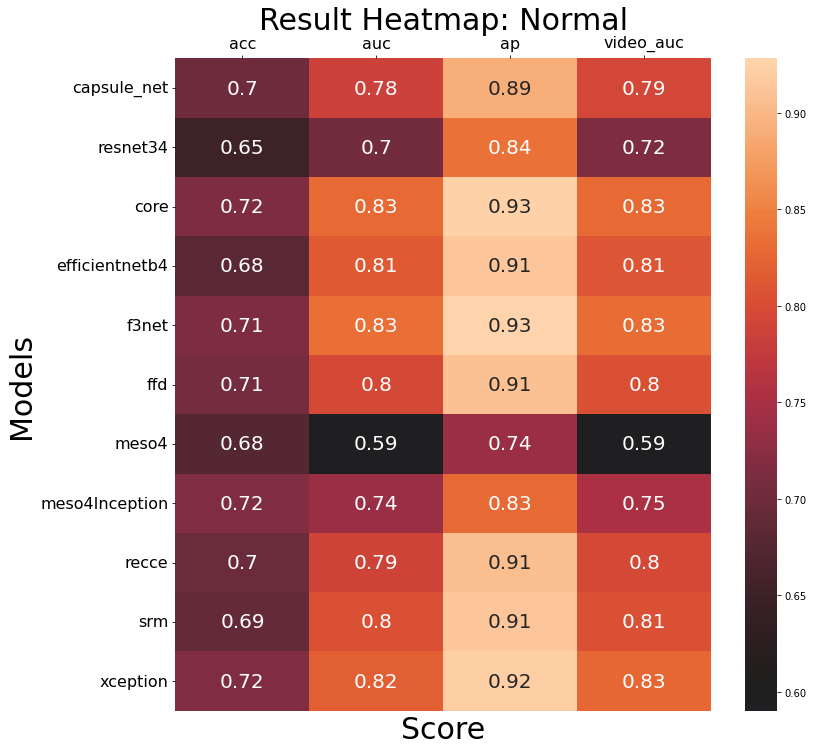

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


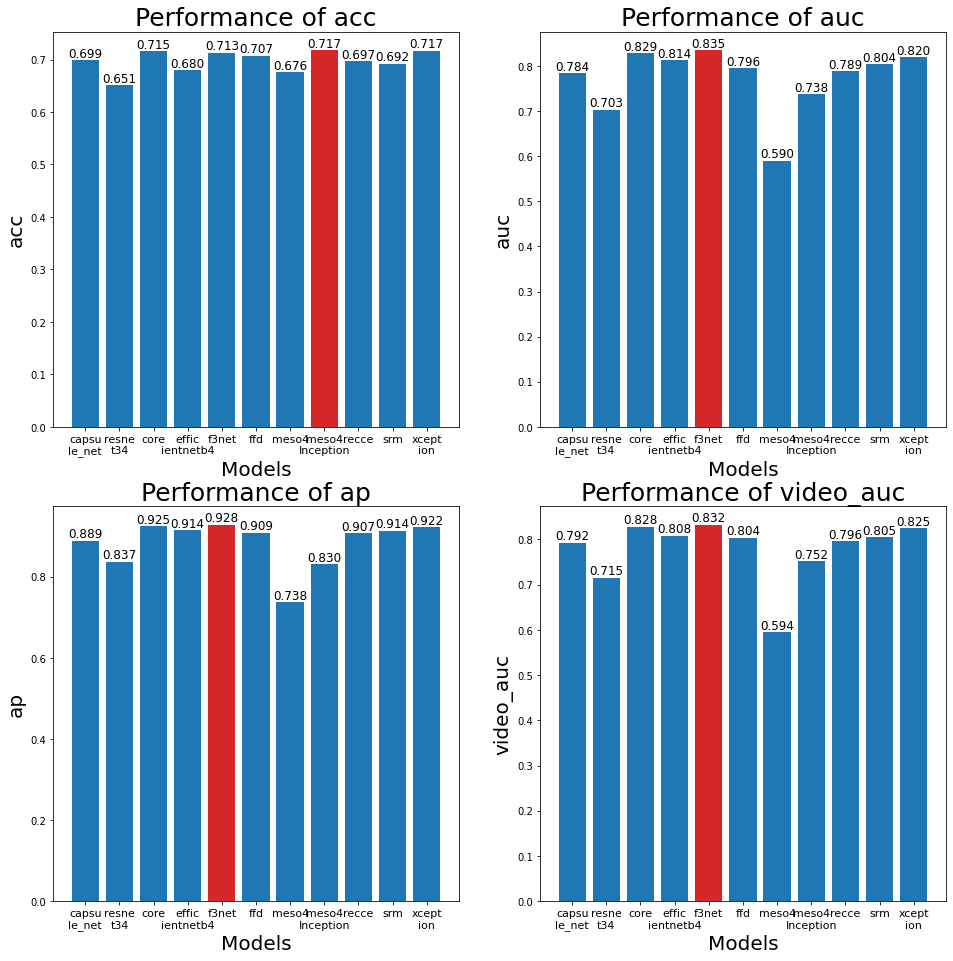

Youtube-real 처리 종료 : 모듈 실행 시간 : 5.63분
Celeb-real 처리 종료 : 모듈 실행 시간 : 11.40분
Celeb-synthesis 처리 종료 : 모듈 실행 시간 : 34.96분


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


Celeb-DF-v1.json generated successfully.
----------------------------------------------------------------------------------------------------
model_name : capsule
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.03it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : cnnaug
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [00:48<00:00, 10.64it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : core
['in_channe

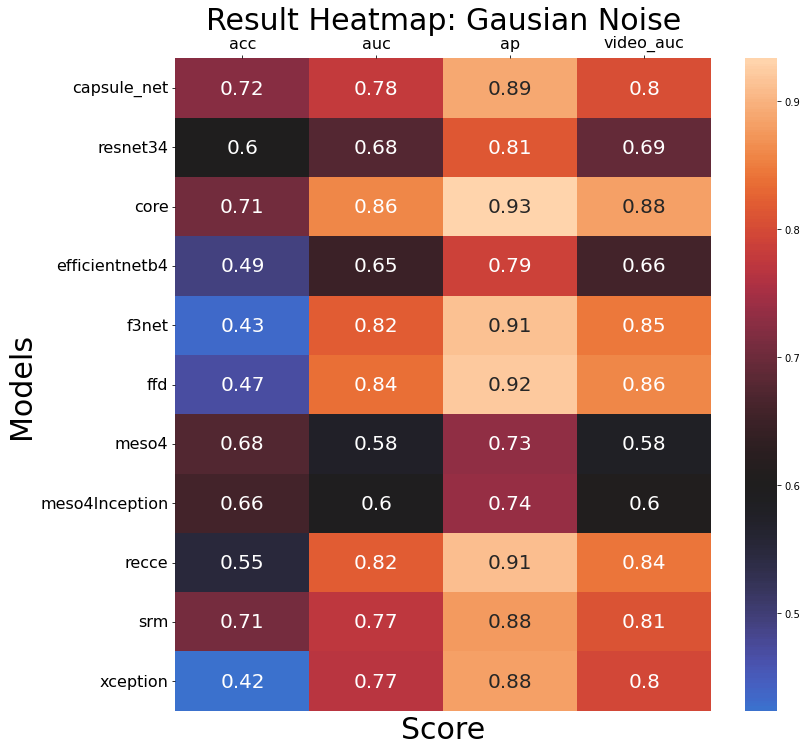

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


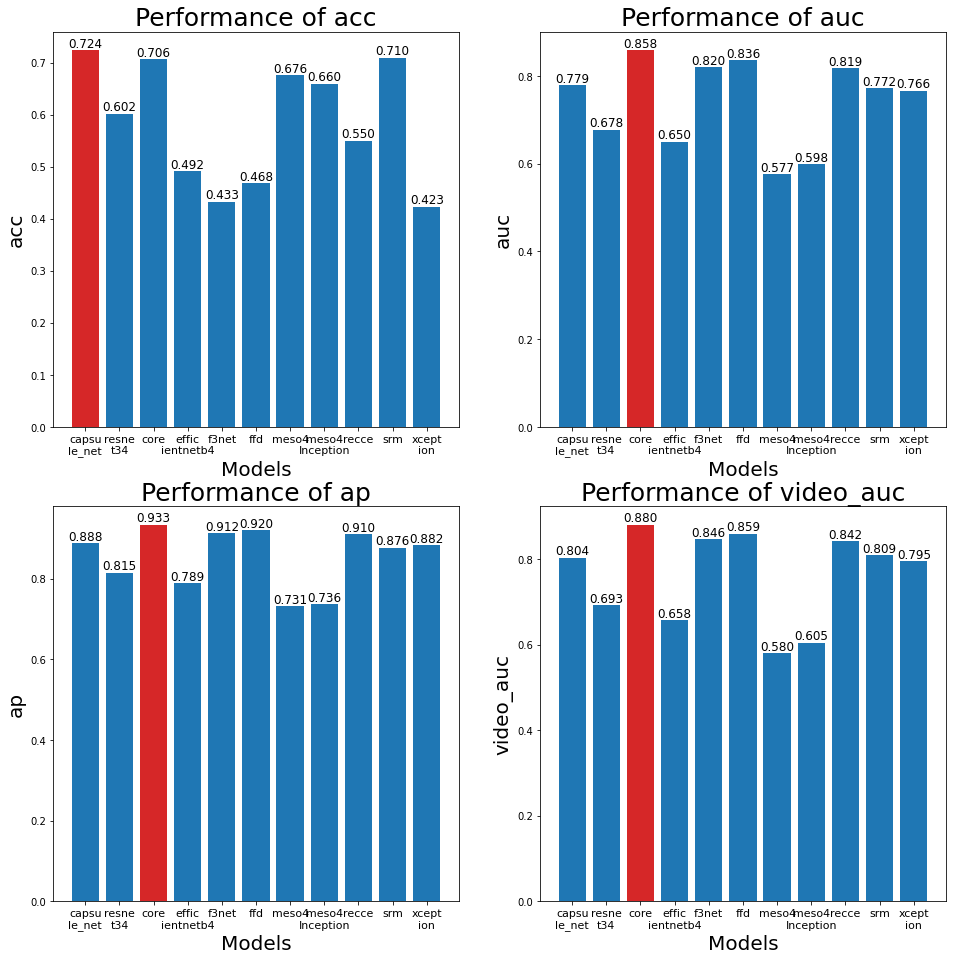

Youtube-real 처리 종료 : 모듈 실행 시간 : 11.59분
Celeb-real 처리 종료 : 모듈 실행 시간 : 23.39분
Celeb-synthesis 처리 종료 : 모듈 실행 시간 : 71.91분


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


Celeb-DF-v1.json generated successfully.
----------------------------------------------------------------------------------------------------
model_name : capsule
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.04it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : cnnaug
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [00:40<00:00, 12.67it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : core
['in_channe

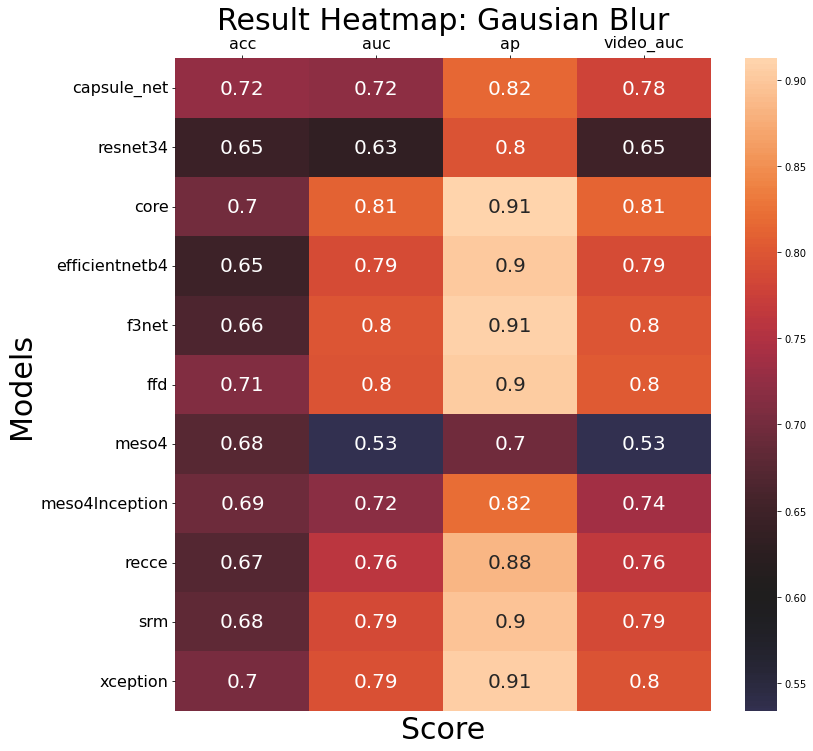

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


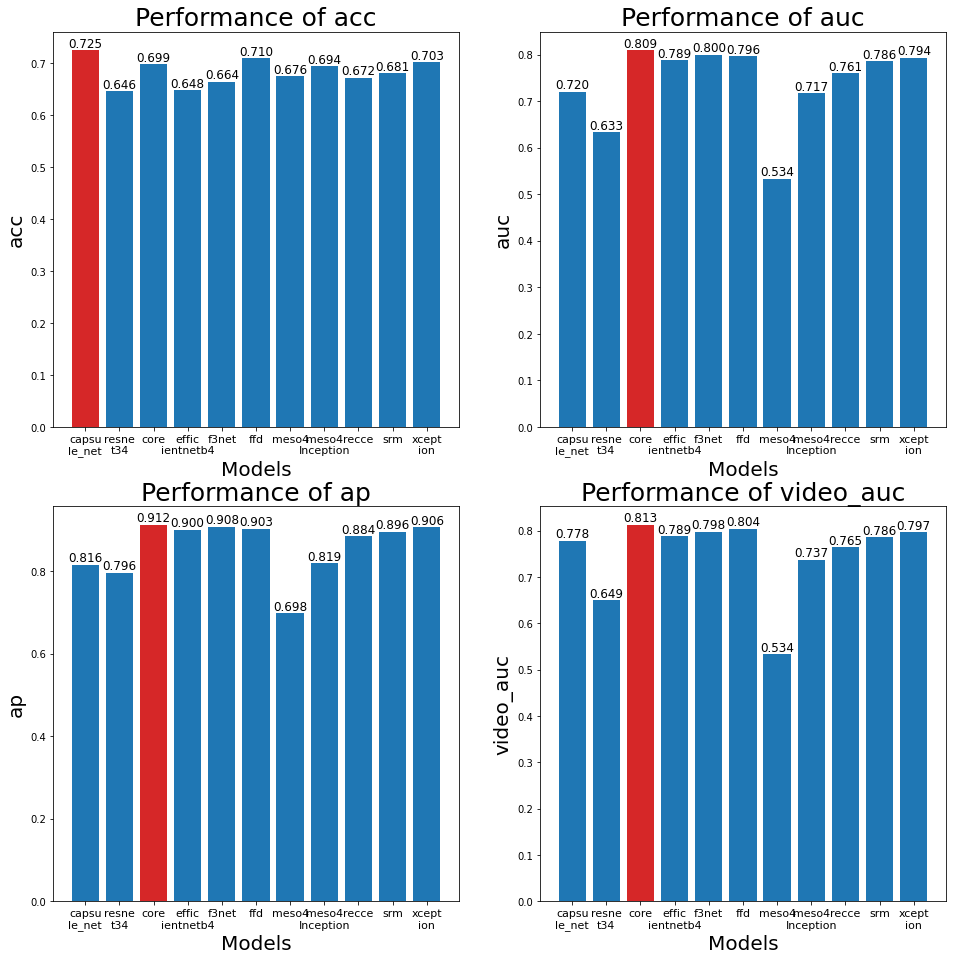

Youtube-real 처리 종료 : 모듈 실행 시간 : 10.73분
Celeb-real 처리 종료 : 모듈 실행 시간 : 21.63분
Celeb-synthesis 처리 종료 : 모듈 실행 시간 : 65.30분


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


Celeb-DF-v1.json generated successfully.
----------------------------------------------------------------------------------------------------
model_name : capsule
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [00:48<00:00, 10.49it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : cnnaug
['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0
===> Load checkpoint done!
100%|█████████████████████████████████████████| 512/512 [00:29<00:00, 17.63it/s]
===> Test Done!
----------------------------------------------------------------------------------------------------
model_name : core
['in_channe

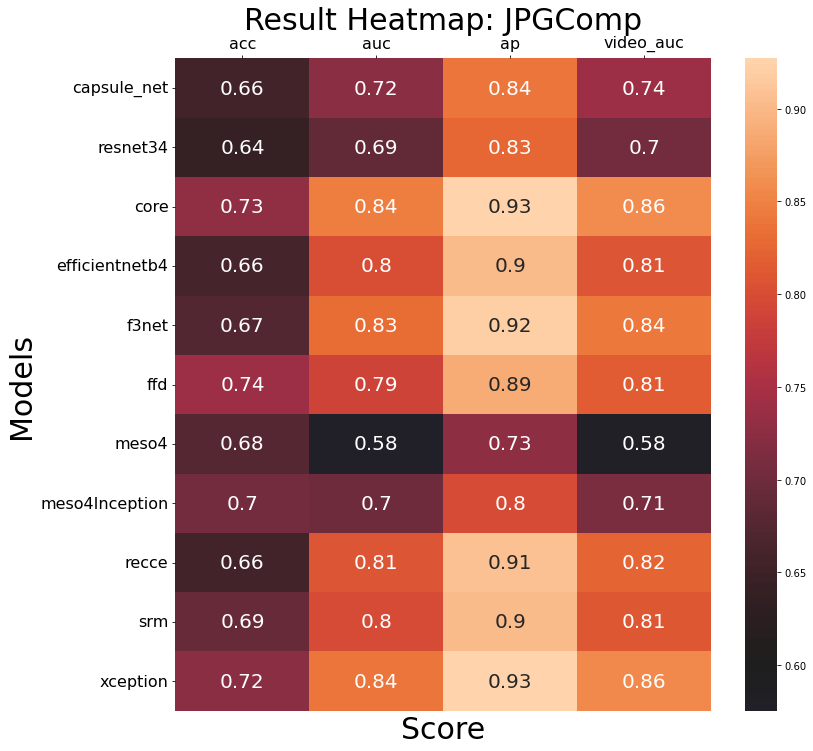

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


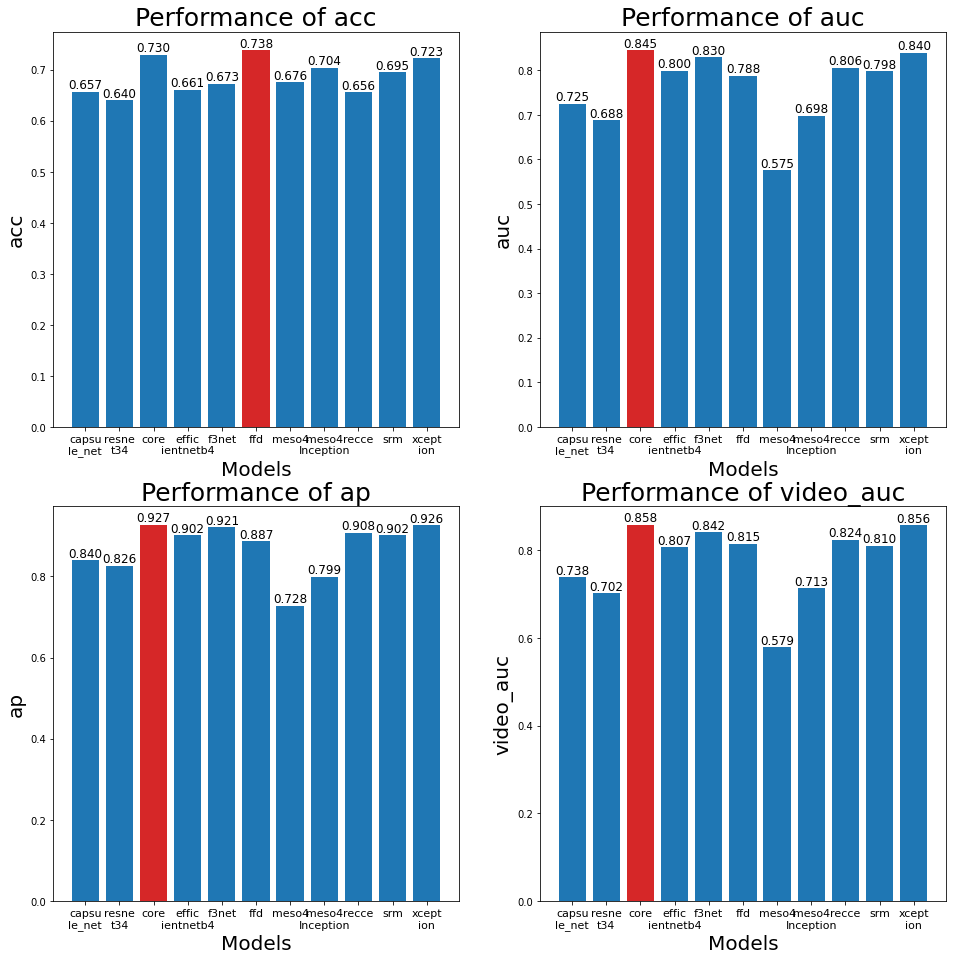

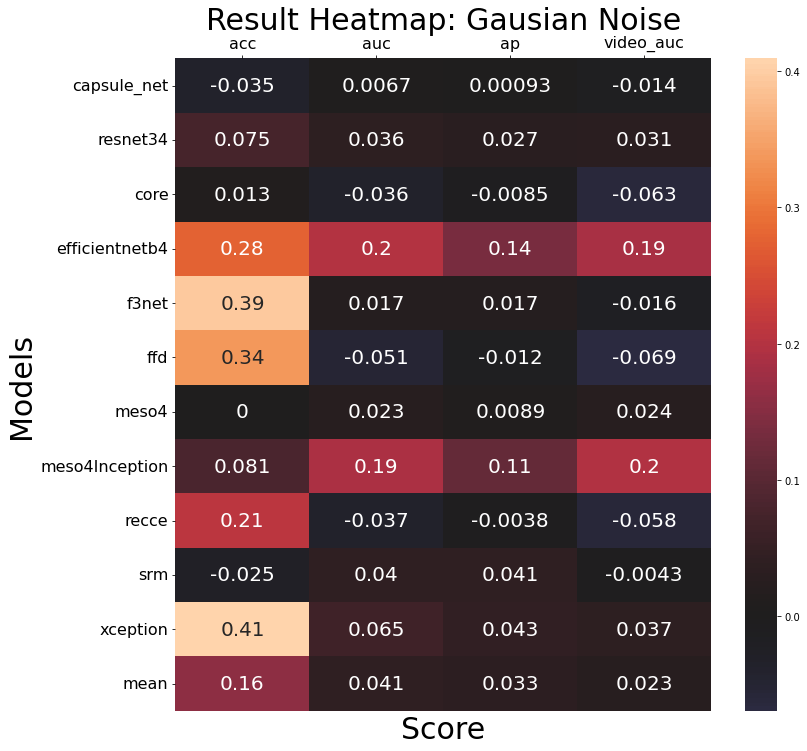

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


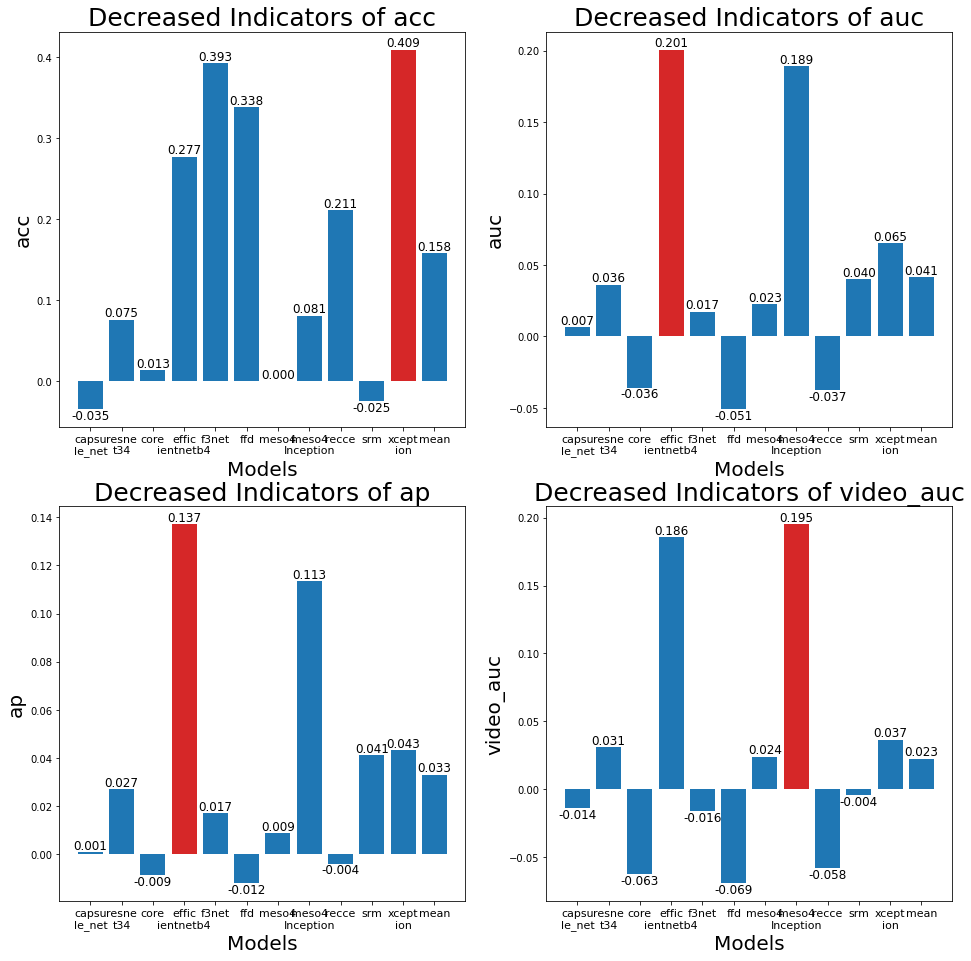

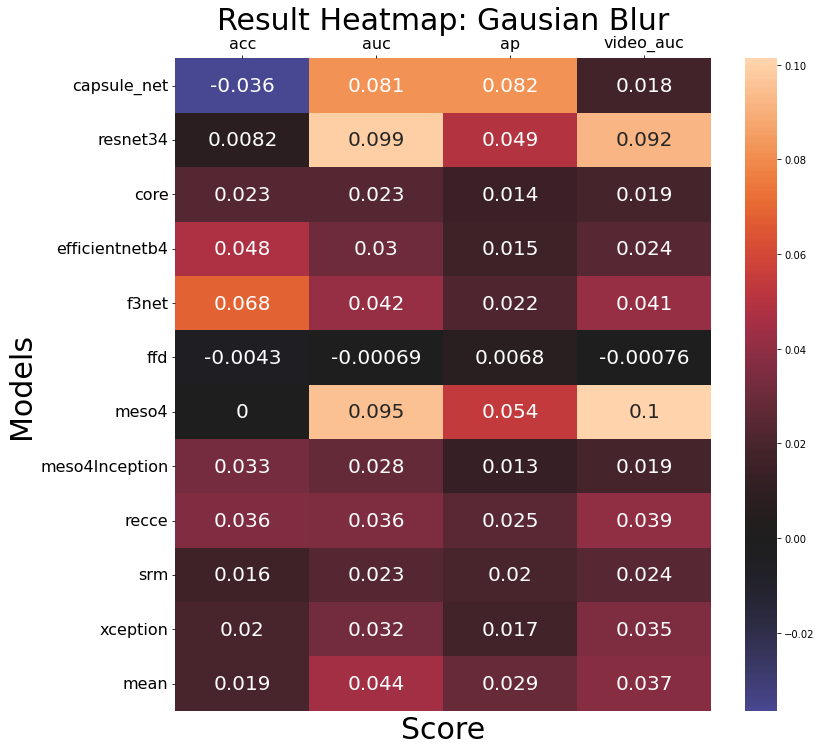

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


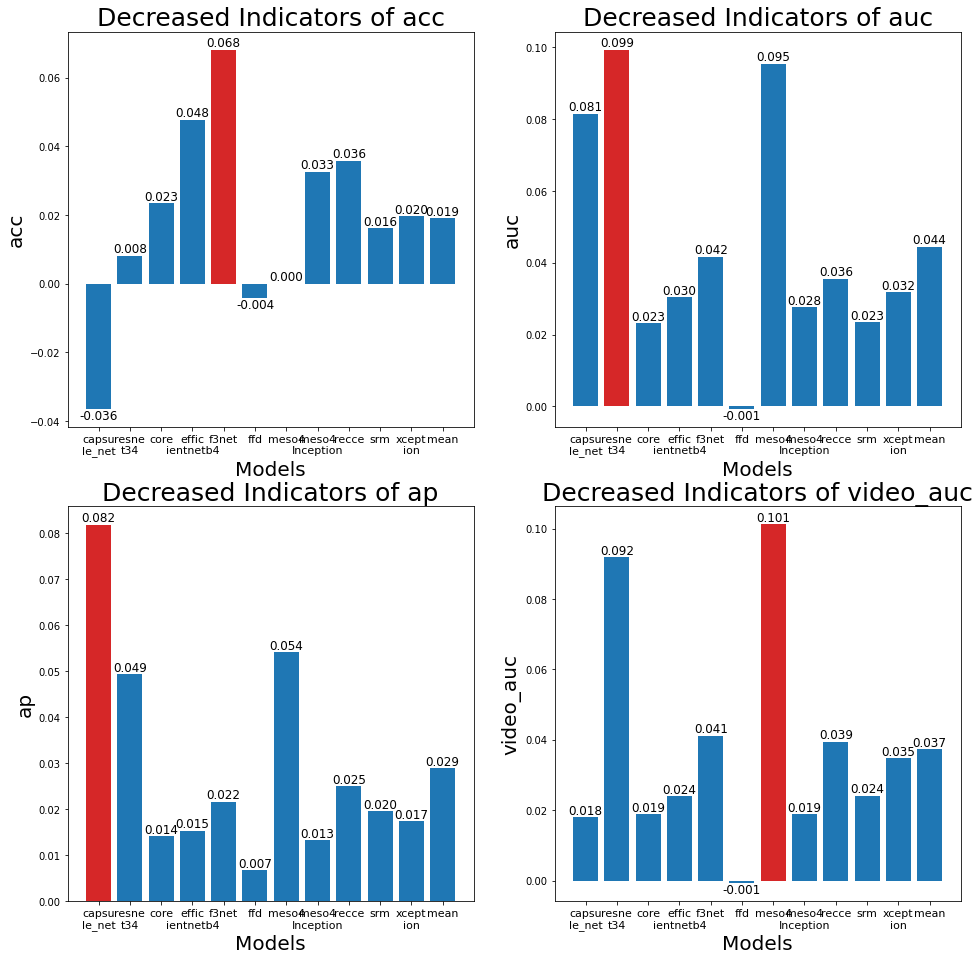

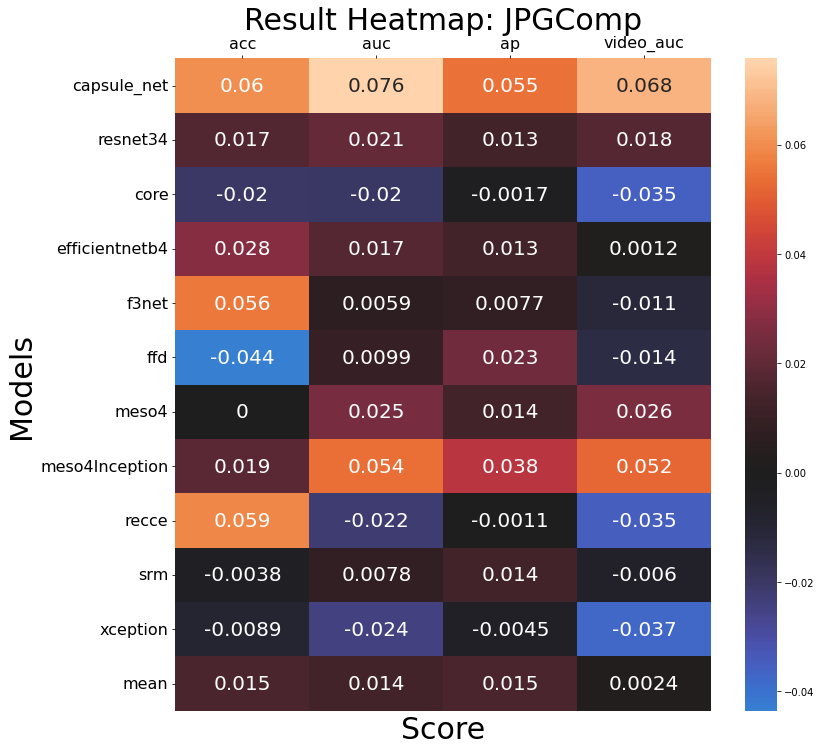

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


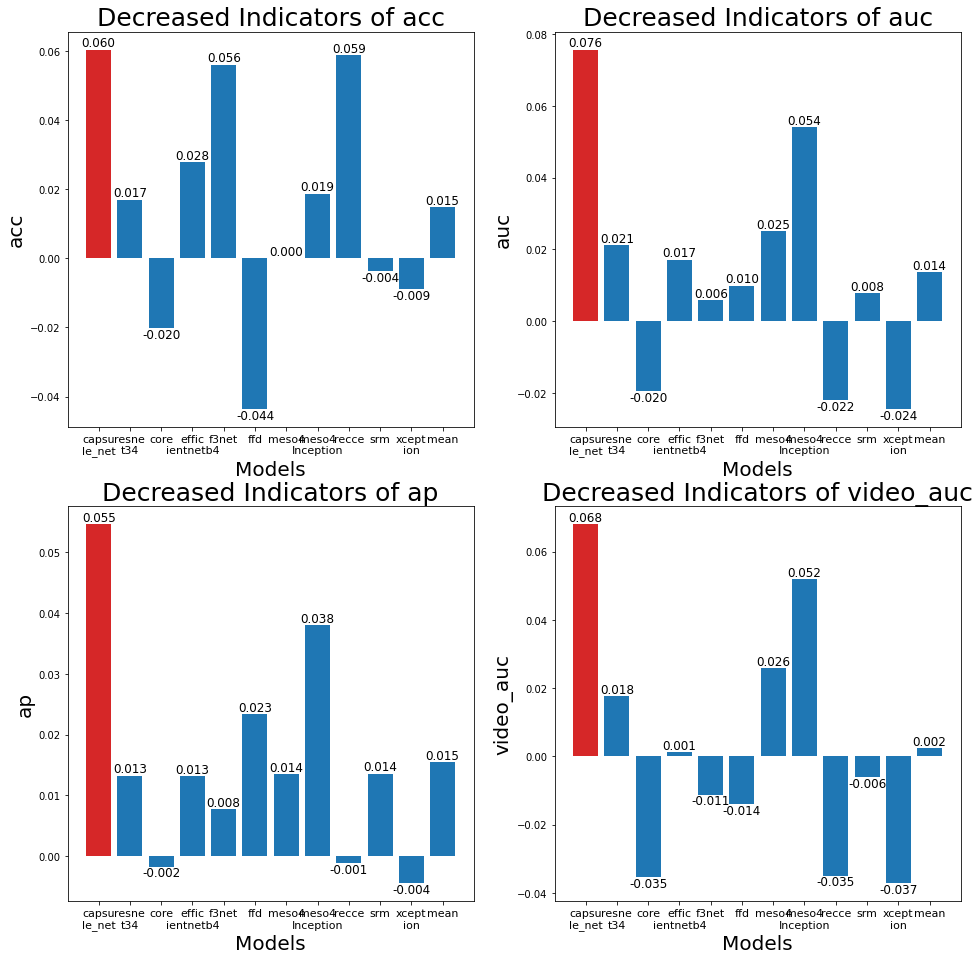

In [51]:
experiment()